# Animal Shelter (XGBoost)


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


# 1. Data Exploration and Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [5]:
def splitSex(df):
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)
    df[["SexuponOutcome", "Sex", "Neutered"]].head()
    
splitSex(df)

In [6]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

Explore the sex and intactness fields visually with respect to outcome. It appears that being neutered is a fair predictor for adoption.

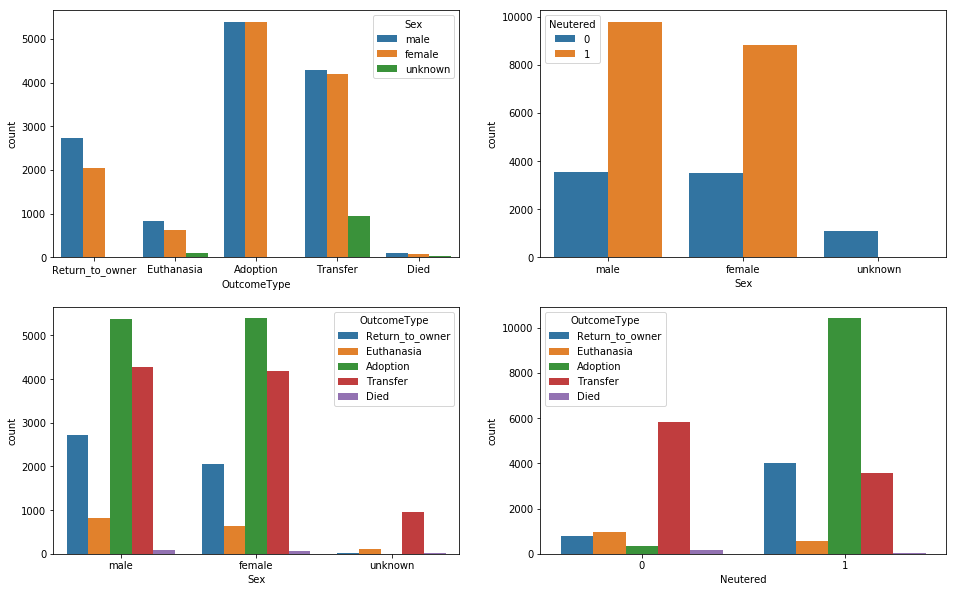

In [7]:
f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=df, x='Sex',hue='OutcomeType', ax=ax2)
sns.countplot(data=df, x="Sex", hue="Neutered", ax=ax3)
sns.countplot(data=df, x="Neutered", hue="OutcomeType", ax=ax4)

Clean up the breed field. Here we determine if an animal is a purebreed or a mix and create a new field encoding this information.

In [8]:
def cleanupBreed(df):
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

Plot normalized ratios of outcomes by breed purity. It looks like purebreed dogs are more likely to be returned to owner (not surprising), however not more likely to be adopted(surprising).

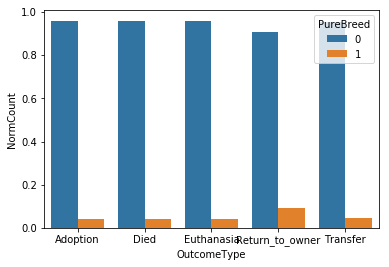

In [9]:
# Normalize counts over imbalanced categories.
# if norm_over_x=True, x counts are normalized. If False, sub_x counts are normalized.
def normalizeCounts(df, x, sub_x, norm_over_x=False):

    agg1 = df.pivot_table(index=[x, sub_x], values=["AnimalID"], aggfunc=len)

    agg1.columns=["NormCount"]
    agg1["NormCount"] = agg1["NormCount"].astype(float)
    agg2 = df.pivot_table(index=[sub_x], values="AnimalID", aggfunc=len)
    #print agg2
    
    x_vals = agg1.index.levels[0].values
    
    #print agg1
    for x_val in x_vals:
        sub_x_vals = agg1.loc[x_val].index.unique().values
        if norm_over_x:
            tot = sum(agg1.loc[x_val, "NormCount"].values)
        
            
        for sub_x_val in sub_x_vals:
            if not norm_over_x:
                tot = agg2.loc[sub_x_val][0]
        
            val = agg1.loc[x_val].loc[sub_x_val,"NormCount"]
            val /= tot
            agg1.loc[x_val].loc[sub_x_val]=val


    agg1 = agg1.reset_index()
    #print agg1
    
    return agg1

# Plot bar chart of outcomes split by pureBreed, normalized over Outcome.
sns.barplot(data=normalizeCounts(df, "OutcomeType", "PureBreed", norm_over_x=True), x="OutcomeType", hue="PureBreed", y="NormCount")

The dog breed potentially encodes information that could improve classifier predictions, such as size of dog, breed popularity, breed temperament and longevity etc. This information, however is difficult to extract from the breed. Instead we encode the breed field into a set of features that can then be used by the classifier. The breed field is transformed into features by calculating a term-document matrix taking the rows in the Breed column as the document corpus. This results in the breed words being vectorized. 

This should allow the classifier to implicitly infer information regarding the breeds which affects the outcome. For example if chihuahuas or chihuahua mixes are unpopular for adoption, any breed mentioning chihuahua should result in a lower probability of adoption in the classifier. If medium sized breeds tend to be adopted more frequently, this should also be a correlation that emerges in the classifier. 

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

breedsVec = TfidfVectorizer()
def preprocessBreed(df):
    #vec = CountVectorizer()
    
    breedsVec.fit(df["Breed"].str.replace("Mix", "").str.replace("/", " ").str.lower())
    
    return breedsVec
    
def processBreed(df):
    breedsTDM = breedsVec.transform(df["Breed"].str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.shape
    
    breedsdf = pd.DataFrame(breedsTDM.toarray())
    breedCols = ["Breed_"+breedsVec.get_feature_names()[i] for i in range(0, breedsTDM.shape[1]) ]
    breedsdf.columns = breedCols
    #print breedsdf.head()

    df = df.join(breedsdf)
    #print df.head()
    return df

preprocessBreed(df)
df = processBreed(df)
df.head()

(26729, 261)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_weimaraner,Breed_welsh,Breed_west,Breed_wheaten,Breed_whippet,Breed_wire,Breed_wirehair,Breed_wirehaired,Breed_wolfhound,Breed_yorkshire
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, JUVENILE, ADULT, SENIOR). Animal shelters do not allow animals to be adopted before they are weaned, therefore the "BABY" bracket should add resultion to our classifier.

In [11]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
processAge(df)


A quick histogram of age distribution shows that most animals at the shelter are younger than about 2 years of age.

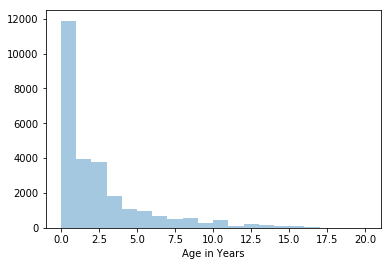

In [12]:

sns.distplot(df.AgeDays/365, bins = 20, kde=False, axlabel="Age in Years")

Visualising outcomes based on these age categories reveals, unsurprisingly, that juveniles are more likely to be adopted than any other age bracket. Babies are less likely to be adopted as shelters usually don't allow them to until they are weaned and are also the most likely to die, or be transferred. Interestingly senior dogs are more likely to be returned to their owner. These facts should have explanatory value in our model.

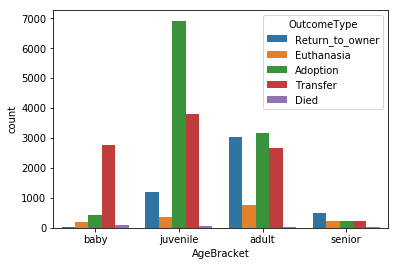

In [13]:
# Plot unnormalized...
sns.countplot(data=df, x="AgeBracket", hue="OutcomeType", order=["baby", "juvenile", "adult", "senior"])


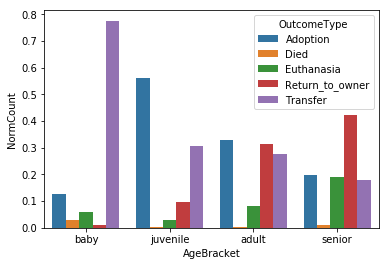

In [14]:

#...and normalized data
sns.barplot(data=normalizeCounts(df, "AgeBracket", "OutcomeType", norm_over_x=True), x="AgeBracket", hue="OutcomeType", y="NormCount", order=["baby", "juvenile", "adult", "senior"])

Here we also take the DateTime column and we split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 17:00 (unsurprising as it is the time most people finish their dayjob)

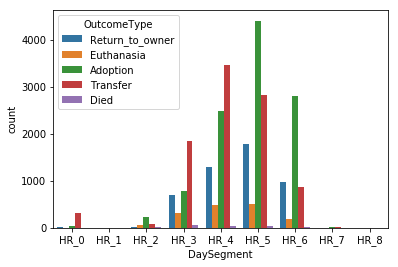

In [15]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)
    df["OutcomeDay"] = df["DateTime"].dt.day
    df["OutcomeMonth"] = df["DateTime"].dt.month
    df["OutcomeHour"] = df["DateTime"].dt.hour
    
processDate(df)

sns.countplot(data=df, x="DaySegment", hue="OutcomeType", order=["HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8"])

Does the day of the week make a difference to the outcomes? 

It looks like adoptions are much more likely during the weekend.

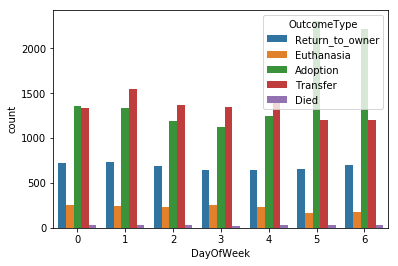

In [16]:
weekdist = pd.DataFrame(data=df[["DateTime", "OutcomeType"]])
weekdist["DayOfWeek"] = weekdist["DateTime"].apply(lambda ts: ts.weekday())

sns.countplot(data=weekdist, x="DayOfWeek", hue="OutcomeType")

Create an "IsWeekend" feature to hopefully help the classifier along.

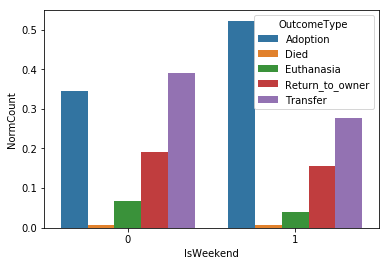

In [17]:
def processWeekend(df):
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)

processWeekend(df)
sns.barplot(data=normalizeCounts(df, "IsWeekend", "OutcomeType", norm_over_x=True), x="IsWeekend", hue="OutcomeType", y="NormCount")

Some more visual exploration relating to the outcome datetime field. Plot outcomes by month, day and hour. One can see interesting cyclicity in this data. In particular the peaks in adoption around Christmas and around July/August (summer holidays!)

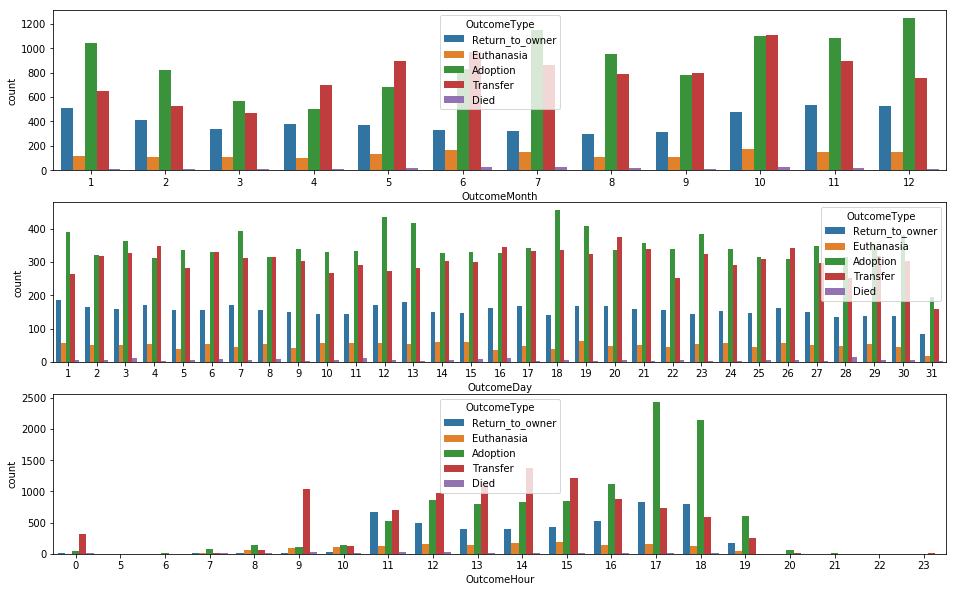

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
sns.countplot(data=df, x="OutcomeMonth", hue="OutcomeType", ax=ax1)
sns.countplot(data=df, x="OutcomeDay", hue="OutcomeType", ax=ax2)
sns.countplot(data=df, x="OutcomeHour", hue="OutcomeType", ax=ax3)
plt.show()

Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

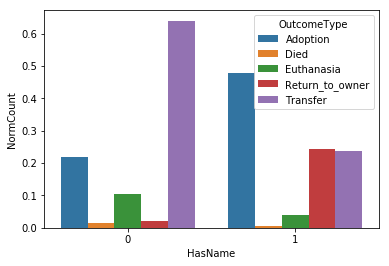

In [19]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

#sns.countplot(data=df, x="HasName", hue="OutcomeType")
sns.barplot(data=normalizeCounts(df, "HasName", "OutcomeType", norm_over_x=True), x="HasName", hue="OutcomeType", y="NormCount")

We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [20]:
df["Color"].unique().size

366

In [21]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
def processColor(df):
    df["SimpleColor"] = df["Color"].apply(lambda c: c.lower().split("/")[0].split(" ")[0])


processColor(df)

print df["SimpleColor"].unique().size
df[["Color", "SimpleColor"]].head()


29


,Color,SimpleColor
0,Brown/White,brown
1,Cream Tabby,cream
2,Blue/White,blue
3,Blue Cream,blue
4,Tan,tan


['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']


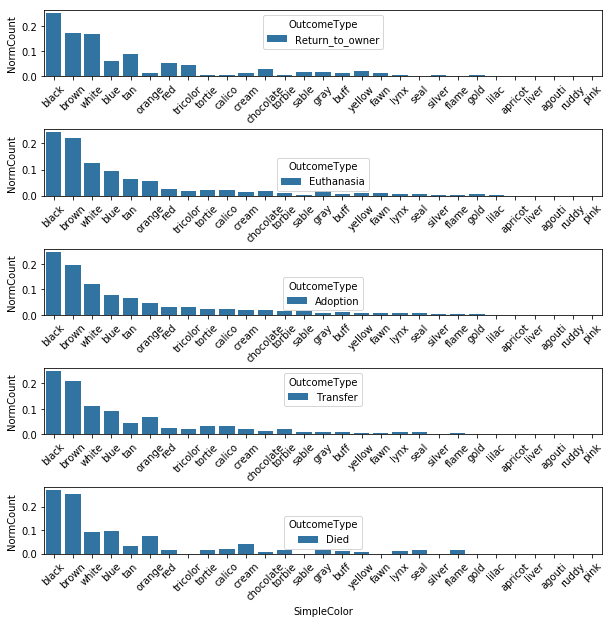

In [22]:
outcomes = df["OutcomeType"].unique()
print outcomes
f, ax1 = plt.subplots(outcomes.size, 1, figsize=(10, 10))

df["SimpleColor"].value_counts().index
for i in range(0,len(outcomes)):
    outcome = outcomes[i]
    ax1[i].tick_params(axis="x", rotation=45)
    sns.barplot(data=normalizeCounts(df.loc[df["OutcomeType"]==outcome,:], x="SimpleColor", sub_x="OutcomeType", norm_over_x=False), x="SimpleColor", hue="OutcomeType", y="NormCount", order=df["SimpleColor"].value_counts().index, ax=ax1[i])
    
f.subplots_adjust(hspace=0.8)

How balanced or unbalanced are our classes?

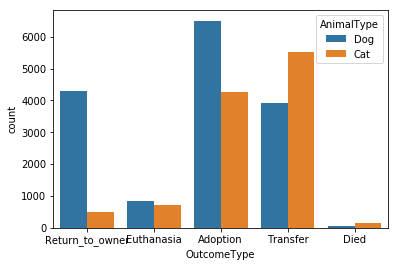

In [23]:
sns.countplot(data=df, x="OutcomeType", hue="AnimalType")

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [24]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [25]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_wolfhound,Breed_yorkshire,AgeDays,AgeBracket,DaySegment,OutcomeDay,OutcomeMonth,OutcomeHour,IsWeekend,SimpleColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,0.0,365.0,juvenile,HR_6,12,2,18,0,brown
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,0.0,365.0,juvenile,HR_4,13,10,12,1,cream
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,0.0,730.0,adult,HR_4,31,1,12,1,blue
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,0.0,21.0,baby,HR_6,11,7,19,0,blue
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,0.0,730.0,adult,HR_4,15,11,12,0,tan


Select only the fields we need for learning.

In [26]:
prepared_df = df.copy()
prepared_df = prepared_df.drop(["AnimalID", "Name", "DateTime", "OutcomeSubtype", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_df.head()


       OutcomeType AnimalType     Sex  Neutered  HasName  PureBreed  \
0  Return_to_owner        Dog    male         1        1          0   
1       Euthanasia        Cat  female         1        1          0   
2         Adoption        Dog    male         1        1          0   
3         Transfer        Cat    male         0        0          0   
4         Transfer        Dog    male         1        0          0   

   Breed_abyssinian  Breed_affenpinscher  Breed_afghan  Breed_airedale  \
0               0.0                  0.0           0.0             0.0   
1               0.0                  0.0           0.0             0.0   
2               0.0                  0.0           0.0             0.0   
3               0.0                  0.0           0.0             0.0   
4               0.0                  0.0           0.0             0.0   

      ...       Breed_wolfhound  Breed_yorkshire  AgeDays  AgeBracket  \
0     ...                   0.0              0.0    365

Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [27]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", None),
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder()),
], df_out=True)




In [28]:
# Transform the target field
classes_array = labelMapper.fit_transform(prepared_df)

# Transform the independent features
prepared_fitted_df = mapper.fit_transform(prepared_df)

# Drop redundant columns to avoid the Dummy Variable Trap
# This is not needed for Tree-based classifiers such as XGBoost, however
# it is good practice anyway
prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType" ], axis=1)

# Convert the features dataframe to an array so as to be able to pass the data
# to the learning functions.
features_array = prepared_fitted_df.values 

#print prepared_fitted_df.columns
#print classes_array.head()
#prepared_fitted_df.head()


As can be seen here the data is severely imbalanced. We will not try to supersample all the minority classes too much because in previous experiments, it degraded the performance of the classifier. We will only supersample the smallest minority class. We will do this using SMOTE.

In [29]:
classnames = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

for c in range(0,5):
    print classnames[c], "=", len(classes_array.loc[classes_array["OutcomeType"]==c])

Adoption = 10769
Died = 197
Euthanasia = 1555
Return_to_owner = 4786
Transfer = 9422


Supersample the data using the SMOTE algorithm so as to mitigate the problem of class imbalance.

NB. Here we used the library downloadable from http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html

In [30]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

# Split the dataset into Train/Test
X_train, X_test, y_train, y_test = train_test_split(features_array, classes_array.values, test_size=0.3, random_state=42)

# Supersample the minitority class slightly.
sm = SMOTE(random_state=42, n_jobs=4, ratio={1:1000})
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

# Restore the y_train array shape as SMOTE reshapes it.
y_train = np.transpose(y_train[np.newaxis])

print features_array.shape
print classes_array.shape
print X_train.shape
print y_train.shape


(26729, 282)
(26729, 1)
(19562, 282)
(19562, 1)


Define a function to plot Receiver Operating Characteristic curves for the outcome class labels.

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plotROCCurves(classes, classlabels, y_test_bin, y_test_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    print int(np.ceil(float(len(classes))/2)), 2
    f, plts = plt.subplots(int(np.ceil(float(len(classes))/2)), 2, figsize=(10, 10))

    plts = plts.ravel()
    lw = 2

    #classlabels=labelMapper.features[0][1].inverse_transform(classes)

    for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
        #plt.subplot(3,2,cls+1)
        if (cls < len(classes)):
            plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
            plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plts[cls].set_xlim([0.0, 1.0])
            plts[cls].set_ylim([0.0, 1.05])
            plts[cls].set_xlabel('False Positive Rate')
            plts[cls].set_ylabel('True Positive Rate')
            plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
            plt.legend(loc="lower right")
        else:
            plts[cls].axis("off")

    f.subplots_adjust(hspace=0.4)
    plt.show()
    


The XGBoost classifier, similar to RandomForest, has a feature importance/selection feature which we use here to perform feature reduction on our dataset.

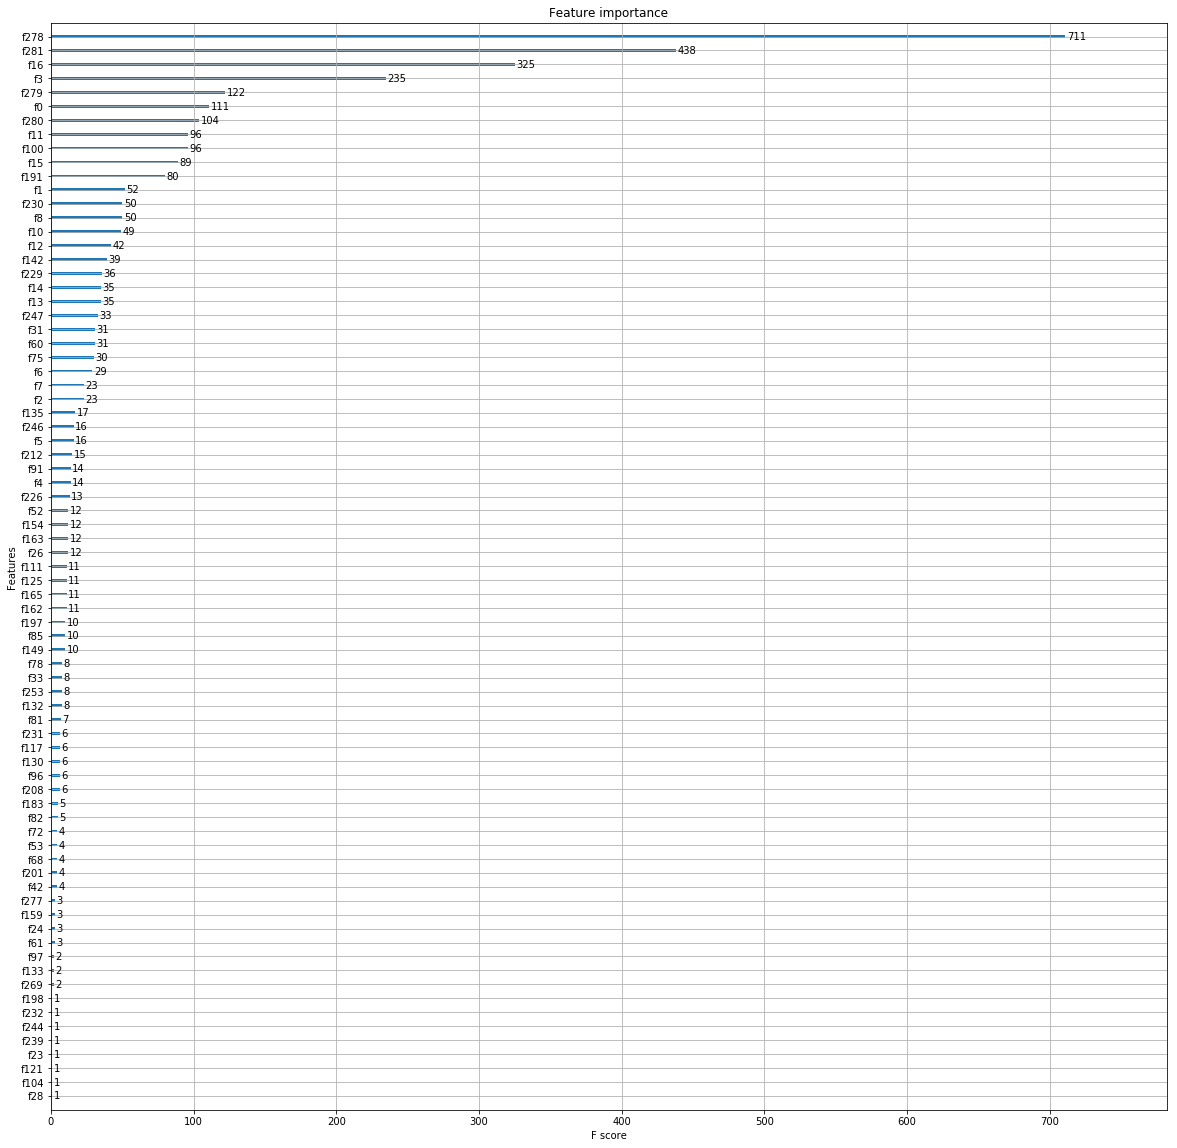

Threshold= 1e-05 : Re-fitting with  77  features instead of  282
f1 score= 0.661408036392
log loss= 0.784608246888
Threshold= 2.78255940221e-05 : Re-fitting with  77  features instead of  282
f1 score= 0.661408036392
log loss= 0.784608246888
Threshold= 7.74263682681e-05 : Re-fitting with  77  features instead of  282
f1 score= 0.661408036392
log loss= 0.784608246888
Threshold= 0.000215443469003 : Re-fitting with  77  features instead of  282
f1 score= 0.661408036392
log loss= 0.784608246888
Threshold= 0.000599484250319 : Re-fitting with  66  features instead of  282
f1 score= 0.66196244704
log loss= 0.784441268569
Threshold= 0.0016681005372 : Re-fitting with  55  features instead of  282
f1 score= 0.662164896674
log loss= 0.784424923914
Threshold= 0.00464158883361 : Re-fitting with  30  features instead of  282
f1 score= 0.659398687445
log loss= 0.784599214634
Threshold= 0.0129154966501 : Re-fitting with  15  features instead of  282
f1 score= 0.657665685005
log loss= 0.784661226557
Th

In [32]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

# Define an instance of XGBoost and fir the training set to it
fselGB = xgb.XGBClassifier(n_jobs=4)
fselGB.fit(X_train, y_train[:,0])

# Plot feature importances visually
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(fselGB, ax=ax)
plt.show()

# In order to determine which features tp select for our model, we iterate on a threshold value.
# Any feature with an importance value smaller than the threshold is removed and the model performance
# is determined in terms of f1 score and log loss. 
# In this way we determine the threshold value at which the performance is maximised and hence which features
# to include in our model.
thresholds_for_test = np.geomspace(0.00001, 0.1, 10, endpoint=True)
f1scores=[]
loglosses=[]
paramsleft=[]
for thresh in thresholds_for_test:
    support = fselGB.feature_importances_>thresh
    print "Threshold=", thresh, ": Re-fitting with ", np.sum(support), " features instead of ", len(support)
    
    GB2 = xgb.XGBClassifier(n_jobs=4)

    GB2.fit(X_train[:,support], y_train[:,0])

    preds = GB2.predict(X_test[:,support])
    proba = GB2.predict_proba(X_test[:,support])

    f1score = f1_score(y_test, preds, average="weighted")
    logloss = log_loss(y_test, proba, labels=GB2.classes_)
    print "f1 score=", f1score
    print "log loss=", logloss

    f1scores.append(f1score)
    loglosses.append(logloss)
    paramsleft.append(np.sum(support))


In [33]:
xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
print xgbresults

[array([  1.00000000e-05,   2.78255940e-05,   7.74263683e-05,
         2.15443469e-04,   5.99484250e-04,   1.66810054e-03,
         4.64158883e-03,   1.29154967e-02,   3.59381366e-02,
         1.00000000e-01]), [77, 77, 77, 77, 66, 55, 30, 15, 5, 2], [0.66140803639182844, 0.66140803639182844, 0.66140803639182844, 0.66140803639182844, 0.6619624470398886, 0.66216489667388745, 0.65939868744466379, 0.65766568500485834, 0.63330681152843038, 0.55490317534709999], [0.7846082468879596, 0.7846082468879596, 0.7846082468879596, 0.7846082468879596, 0.7844412685686093, 0.78442492391410079, 0.78459921463360505, 0.78466122655734771, 0.82796114345719574, 0.97893626503678888]]


Plot the resultant f1 scores and log loses vs. threshold in order to get a visual understanding of the effect of feature reduction on the model performance.
Use the calculated scores to determine the optimal threshold.

Will use threshold  0.0016681005372
[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True False False False False False False False
 False False  True False False False False  True False  True False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
  True False False False False False False False False False False False
 False False False  True False False  True False False  True False False
 False  True False False False False False  True False False False False
  True False False False  True False False False False False False False
 False False False  True False False False False False  True False False
 False False False False False  True False False False False  True False
  True False False  True False False False False False False  True False
 False False False False False  True False False False False  True False
 False False Fa

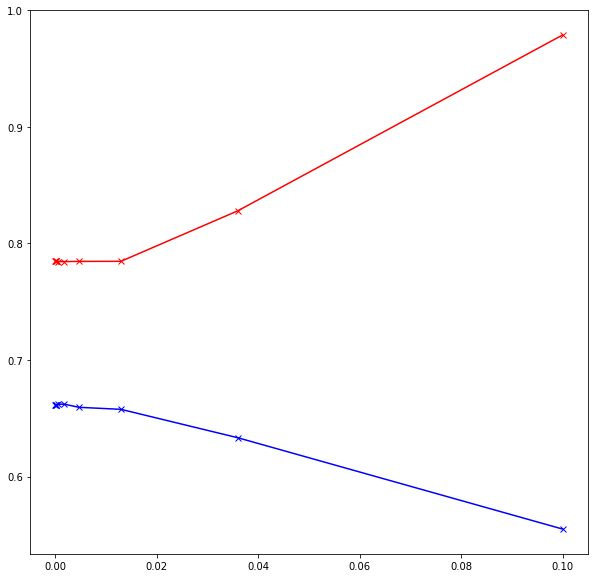

In [34]:
f, ax = plt.subplots(1, figsize=(10,10))
plt.plot(thresholds_for_test, f1scores, "bx-", thresholds_for_test, loglosses, "rx-")

f1_thresh = np.argsort(f1scores)[-1] # index of best f1 score
ll_thresh = np.argsort(loglosses)[0] # index of best log loss

# Average the two
final_threshold = np.average((thresholds_for_test[f1_thresh], thresholds_for_test[ll_thresh]))

# final_support is now a boolean array masking out the most important features.
final_support = fselGB.feature_importances_>=final_threshold

print "Will use threshold ", final_threshold
print final_support

# Save the contents of X_test before feature reduction.
X_test_pre_red = X_test

# Reduce the features on the training and test sets
X_train = X_train[:,final_support]
X_test = X_test[:, final_support]



Print the selected column names in order of importance. 

We can see that the features identified as expanatory in the Data Exploration section also appear here. This is expected and is a good indication that we are selecting the correct fields.

It is also interesting to see which breeds/breed features are he most important.

In [35]:
sortedIndexes = np.argsort(fselGB.feature_importances_)[::-1]
colnames= prepared_fitted_df.columns.values
#colnames = np.append(colnames, "SimpleOutcome")

print colnames[sortedIndexes][final_support[sortedIndexes]]

['AgeDays' 'OutcomeHour' 'HasName' 'Neutered' 'OutcomeDay' 'AnimalType'
 'OutcomeMonth' u'Breed_domestic' 'DaySegment_HR_3' 'IsWeekend'
 u'Breed_pit' 'Sex_female' u'Breed_shorthair' 'DaySegment_HR_0'
 'DaySegment_HR_2' 'DaySegment_HR_4' u'Breed_jack' u'Breed_shih'
 'DaySegment_HR_6' 'DaySegment_HR_5' u'Breed_standard' u'Breed_basset'
 u'Breed_bull' u'Breed_chihuahua' 'AgeBracket_baby' 'Sex_male'
 'AgeBracket_juvenile' u'Breed_husky' 'AgeBracket_adult'
 u'Breed_staffordshire' u'Breed_rottweiler' 'PureBreed' u'Breed_dachshund'
 u'Breed_shepherd' u'Breed_medium' u'Breed_longhair' u'Breed_apso'
 u'Breed_boston' u'Breed_mastiff' u'Breed_miniature' u'Breed_hair'
 u'Breed_flat' u'Breed_labrador' u'Breed_pomeranian' u'Breed_corgi'
 u'Breed_himalayan' u'Breed_beagle' u'Breed_terrier' u'Breed_chow'
 u'Breed_cocker' u'Breed_doberman' u'Breed_german' u'Breed_siamese'
 u'Breed_heeler' u'Breed_retriever']


In [ ]:
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
# We use the genetic algorithm cross validation search library at https://github.com/rsteca/sklearn-deap 
# in order to optimize the XGBoost Hyperparameters.
from evolutionary_search import EvolutionaryAlgorithmSearchCV

# Ideally we use approx. 10 folds
k_fold = 10
  
# Use Stratified KFold so as to mitigate the effects of the imbalanced dataset.
# Stratified k-fold makes sure that the cross validation folds are always selected with the same 
# ratio of outcome classes
cv = StratifiedKFold(y_train[:,0],n_folds=k_fold,shuffle=True)
  
# initialize the classifier
GB = xgb.XGBClassifier()
  
# Define the hyperparamer ranges inside which we want to optimize our model
param_grid = {'max_depth': [500],
              'learning_rate': np.arange(0.1, 2, 0.1),
              'objective':['multi:softprob'],
              'n_jobs': [2],
              'missing': [np.nan],
              'reg_alpha': np.geomspace(0.01, 100, 30, endpoint=True),
              'colsample_bytree': np.arange(0.1, 1, 0.1),
              'colsample_bylevel': np.arange(0.1, 1, 0.1),
              'subsample': np.arange(0.1, 1, 0.1),
              'n_estimators': np.arange(50, 500, 50)}
  


search_GB = EvolutionaryAlgorithmSearchCV(estimator=GB,
                                   params=param_grid,
                                   scoring="neg_log_loss",
                                   cv=cv,
                                   verbose=10,
                                   population_size=100,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=10,
                                   generations_number=20,
                                   n_jobs=2)

search_GB.fit(X_train,y_train[:,0])
print ' ',search_GB.best_score_
print ' ',search_GB.best_params_



Types [1, 2, 2, 1, 2, 2, 1, 2, 2, 1] and maxint [8, 8, 29, 0, 8, 0, 0, 18, 8, 0] detected
--- Evolve in 3739770 possible combinations ---
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.1, colsample_bylevel=0.5, n_estimators=250, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.5, colsample_bylevel=0.7, n_estimators=50, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.5, colsample_bylevel=0.7, n_estimators=50, subsample=0.1, objective=multi:softprob, max_depth=500, score=-1.15540327604, total=  15.8s
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.5, colsample_bylevel=0.7, n_estimators=50, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_byt

[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.1, colsample_bylevel=0.2, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.1, colsample_bylevel=0.2, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.758108743378, total=  36.1s
[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.1, colsample_bylevel=0.2, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.1, colsample_bylevel=0.5, n_estimators=250, subsample=0.7, objective=multi:softprob, max_depth=500, score=-1.40776899343, total= 1.4min
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.1, colsample_bylevel=0.5, n_estimators=250, subsample=0.7, objecti

[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.1, colsample_bylevel=0.5, n_estimators=250, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.6, colsample_bylevel=0.2, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500, score=-1.07582992888, total=  28.6s
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.6, colsample_bylevel=0.2, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.6, colsample_bylevel=0.2, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500, score=-1.10036173056, total=  26.3s
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.6, colsample_bylevel=0.2, n_estimators=350, subsample=0.1, ob

[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.9, colsample_bylevel=0.3, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500, score=-3.49850980921, total=  50.0s
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.9, colsample_bylevel=0.3, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=400, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.845209313065, total=  32.6s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=400, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.9, colsample_bylevel=0.3, n_estimators=300, subsample=0.9, objectiv

[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.5, colsample_bylevel=0.5, n_estimators=400, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.5, colsample_bylevel=0.5, n_estimators=400, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.788224802126, total=  31.4s
[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.5, colsample_bylevel=0.5, n_estimators=400, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.6, colsample_bylevel=0.6, n_estimators=200, subsample=0.4, objective=multi:softprob, max_depth=500, score=-1.20146990857, total=  58.7s
[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.6, colsample_bylevel=0.6, n_estimators=200, subsample=0.4, obj

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.7, colsample_bylevel=0.3, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.4, colsample_bylevel=0.4, n_estimators=50, subsample=0.5, objective=multi:softprob, max_depth=500, score=-1.26014438111, total=  18.5s
[CV] reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.4, colsample_bylevel=0.4, n_estimators=50, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.4, colsample_bylevel=0.4, n_estimators=50, subsample=0.5, objective=multi:softprob, max_depth=500, score=-1.2704614313, total=  18.7s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.8, colsample_bylevel=0.3, n_estimators=400, subsample=0.5, objective=m

[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.8, colsample_bylevel=0.3, n_estimators=400, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.815739833489, total= 1.2min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.8, colsample_bylevel=0.3, n_estimators=400, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.4, colsample_bylevel=0.2, n_estimators=450, subsample=0.8, objective=multi:softprob, max_depth=500, score=-1.27035646125, total= 1.8min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.4, colsample_bylevel=0.2, n_estimators=450, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.8, colsample_bylevel=0.3, n_estimators=400, subsample=0.5, object

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.4, colsample_bylevel=0.2, n_estimators=450, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=400, subsample=0.2, objective=multi:softprob, max_depth=500, score=-10.415053445, total= 1.3min
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=400, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=400, subsample=0.2, objective=multi:softprob, max_depth=500, score=-10.1999315324, total= 1.4min
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objec

[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.2, n_estimators=300, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.2, n_estimators=300, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.768347269665, total=  34.9s
[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.2, n_estimators=300, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.2, n_estimators=300, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.765184245757, total=  32.4s
[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.2, n_estimators=300, subsample=0.2, objec

[CV]  reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.965984688545, total=  28.8s
[CV] reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.942175406807, total=  28.8s
[CV] reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=400, subsample=0.1, objective

[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.7, colsample_bylevel=0.1, n_estimators=50, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.775276730325, total=   5.6s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.9, n_estimators=250, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.9, n_estimators=250, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.813669733595, total=  16.8s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.9, n_estimators=250, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.9, n_estimators=250, subsample=0.2, objective=

[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.757353240471, total=  19.1s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.794560581225, total=  18.6s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.7, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.126896100317, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=1.3, colsample_bylevel=0.6, n_estimators=200, subsample=0.3, objective=multi:softprob, max_depth=500, score=-2.46679857363, total= 1.1min
[CV] reg_alpha=0.126896100317, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=1.3, colsample_bylevel=0.6, n_estimators=200, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.7, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.774345912853, total=  34.4s
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.7, n_estimators=150, subsample=0.6, obj

[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.3, n_estimators=100, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.757424152169, total=  17.2s
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.3, n_estimators=100, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.3, n_estimators=100, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.780489286391, total=  17.2s
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.3, n_estimators=100, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.3, n_estimators=100, subsample=0.8, objective

[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.6, colsample_bylevel=0.5, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.90086500347, total=  25.9s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.6, colsample_bylevel=0.5, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.3, n_estimators=300, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.822181851463, total=  17.1s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.3, n_estimators=300, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.6, colsample_bylevel=0.5, n_estimators=350, subsample=0.5, objective=multi:softprob, max_de

[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=1.17210229753, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.7, colsample_bylevel=0.8, n_estimators=350, subsample=0.9, objective=multi:softprob, max_depth=500, score=-1.09027932118, total=  49.0s
[CV] reg_alpha=1.17210229753, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.7, colsample_bylevel=0.8, n_estimators=350, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.5, objective=multi:softprob, max_depth=500, score=-1.77891417012, total=  38.7s
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.5, object

[CV] reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.2, colsample_bylevel=0.4, n_estimators=250, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=100, subsample=0.8, objective=multi:softprob, max_depth=500, score=-1.58548540725, total=  30.1s
[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=100, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=100, subsample=0.8, objective=multi:softprob, max_depth=500, score=-1.62344551728, total=  30.8s
[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=100, subsample=0.8, objecti

[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.7, colsample_bylevel=0.2, n_estimators=450, subsample=0.6, objective=multi:softprob, max_depth=500, score=-1.56826699324, total=  52.0s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.7, colsample_bylevel=0.2, n_estimators=450, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.2, colsample_bylevel=0.7, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500, score=-1.34287344123, total= 1.6min
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.2, colsample_bylevel=0.7, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.7, colsample_bylevel=0.2, n_estimators=450, subsample=0.6, obje

[CV] reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=100, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=100, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.886693207382, total=   9.2s
[CV] reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=100, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=100, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.869605048897, total=   9.1s
[CV] reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=100, subsample=0.7, objective=

[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=250, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.5, colsample_bylevel=0.4, n_estimators=200, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.97753087112, total=  28.3s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.5, colsample_bylevel=0.4, n_estimators=200, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.5, colsample_bylevel=0.4, n_estimators=200, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.939495168469, total=  29.3s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.1, colsample_bylevel=0.5, n_estimators=200, subsample=0.3, objective=m

[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.8, colsample_bylevel=0.9, n_estimators=50, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.8, colsample_bylevel=0.9, n_estimators=50, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.939778727361, total=  10.8s
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.8, colsample_bylevel=0.9, n_estimators=50, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=250, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.877539773367, total=  37.6s
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=250, subsample=0.6, objective=m

[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=250, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=1.5, colsample_bylevel=0.2, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.828219487165, total=  23.9s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=1.5, colsample_bylevel=0.2, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=1.5, colsample_bylevel=0.2, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.838607845703, total=  24.0s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=1.5, colsample_bylevel=0.2, n_estimators=400, subsample=0.1, objective

[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.7, colsample_bylevel=0.9, n_estimators=350, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.9, colsample_bylevel=0.9, n_estimators=200, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.771355905403, total=  43.2s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.9, colsample_bylevel=0.9, n_estimators=200, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.9, colsample_bylevel=0.9, n_estimators=200, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.78145142274, total=  43.3s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.9, colsample_bylevel=0.9, n_estimators=200, subsample=0.2, objective=m

[CV] reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=200, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.7, colsample_bylevel=0.9, n_estimators=350, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.892340302513, total= 1.9min
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.7, colsample_bylevel=0.9, n_estimators=350, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=200, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.813544193847, total= 1.4min
[CV] reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=200, subsample=0.4, objecti

[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.8, colsample_bylevel=0.3, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-3.49536302113, total= 1.2min
[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.8, colsample_bylevel=0.3, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.4, colsample_bylevel=0.4, n_estimators=450, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.792678276679, total= 1.5min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.4, colsample_bylevel=0.4, n_estimators=450, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.8, colsample_bylevel=0.3, n_estimators=350, subsample=0.4, obje

[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.9, colsample_bylevel=0.9, n_estimators=450, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.7, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.96372239359, total= 1.0min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.7, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.9, colsample_bylevel=0.9, n_estimators=450, subsample=0.3, objective=multi:softprob, max_depth=500, score=-1.6118130321, total= 1.3min
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.9, colsample_bylevel=0.9, n_estimators=450, subsample=0.3, objecti

[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.4, colsample_bylevel=0.4, n_estimators=400, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.9, colsample_bylevel=0.4, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500, score=-1.07783967761, total=  52.8s
[CV] reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.9, colsample_bylevel=0.4, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.9, colsample_bylevel=0.4, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500, score=-1.10944702076, total=  52.6s
[CV] reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.9, colsample_bylevel=0.4, n_estimators=200, subsample=0.5, objectiv

[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.782464118549, total=  22.0s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.762761676774, total=  21.4s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.5, colsample_bylevel=0.4, n_estimators=150, subsample=0.3, objective=

[CV] reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.5, colsample_bylevel=0.7, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=300, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.766738139446, total=  50.2s
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=300, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.5, colsample_bylevel=0.7, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.800418643473, total=  24.4s
[CV] reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.5, colsample_bylevel=0.7, n_estimators=300, subsample=0.3, objectiv

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=450, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.775008032726, total=  16.7s
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.768142265959, total=  17.7s
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.4, objectiv

[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=450, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.886882542414, total=  28.6s
[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.3, colsample_bylevel=0.8, n_estimators=350, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.747796409149, total=  51.9s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, obje

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.772291263433, total=  24.4s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.76094665895, total=  25.0s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=m

[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.7, colsample_bylevel=0.1, n_estimators=300, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.7, colsample_bylevel=0.1, n_estimators=300, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.81193569146, total=  19.8s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.7, colsample_bylevel=0.1, n_estimators=300, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.7, colsample_bylevel=0.1, n_estimators=300, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.809509873622, total=  19.5s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.7, colsample_bylevel=0.1, n_estimators=300, subsample=0.8, object

[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.7, n_estimators=100, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.968739154333, total=   8.1s
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.9, colsample_bylevel=0.7, n_estimators=200, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.7, n_estimators=100, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.7, n_estimators=100, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.95113972684, total=   8.4s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.0, colsample_bylevel=0.7, n_estimators=100, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  

[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.9, colsample_bylevel=0.7, n_estimators=200, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.3, colsample_bylevel=0.7, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.785364660649, total=  32.8s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.3, colsample_bylevel=0.7, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.9, colsample_bylevel=0.7, n_estimators=200, subsample=0.7, objective=multi:softprob, max_depth=500, score=-1.07293080493, total=  19.9s
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=150, subsample=0.4, objecti

[CV]  reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.9, colsample_bylevel=0.5, n_estimators=450, subsample=0.2, objective=multi:softprob, max_depth=500, score=-2.09034189043, total= 1.6min
[CV] reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.9, colsample_bylevel=0.5, n_estimators=450, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=150, subsample=0.4, objective=multi:softprob, max_depth=500, score=-1.87955406852, total= 1.1min
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=150, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=150, subsample=0.4, obj

[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.8, colsample_bylevel=0.1, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.949969592888, total=  21.9s
[CV] reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.8, colsample_bylevel=0.1, n_estimators=400, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.83450658632, total=  27.5s
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.8, colsample_bylevel=0.1, n_estimators=400, subsample=0.1, objective=m

[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi:softprob, max_depth=500, score=-1.3442270577, total=  19.2s
[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.3, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=250, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.921154792438, total= 1.4min
[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=250, subsample=0.4, objective=m

[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500, score=-1.03806835825, total=  33.3s
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500, score=-1.01812269177, total=  32.9s
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, ob

[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=1.4, colsample_bylevel=0.4, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.813721344161, total= 1.2min
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=1.4, colsample_bylevel=0.4, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.758585584535, total= 1.6min
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=1.4, colsample_bylevel=0.4, n_estimators=350, subsample=0.5, objective

[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.764345257491, total= 1.3min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.746180944647, total= 1.4min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=

[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.7, colsample_bylevel=0.4, n_estimators=450, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.4, colsample_bylevel=0.1, n_estimators=450, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.927244423559, total= 1.1min
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=1.9, colsample_bylevel=0.8, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.7, colsample_bylevel=0.4, n_estimators=450, subsample=0.1, objective=multi:softprob, max_depth=500, score=-2.65470550149, total=  51.9s
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.7, colsample_bylevel=0.4, n_estimators=450, subsample=0.1, objecti

[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=50, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=50, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.764693582117, total=  12.3s
[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=50, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=50, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.755355985732, total=  12.1s
[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=50, subsample=0.6, objec

[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=1.9, colsample_bylevel=0.8, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.5, colsample_bylevel=0.7, n_estimators=150, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.79707836147, total=  38.3s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.5, colsample_bylevel=0.7, n_estimators=150, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.5, colsample_bylevel=0.7, n_estimators=150, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.813378482113, total=  38.3s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.5, colsample_bylevel=0.7, n_estimators=150, subsample=0.9, objective=m

[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.76698934915, total=  27.4s
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.0, colsample_bylevel=0.6, n_estimators=100, subsample=0.6, objective=multi:softprob, max_depth=500, score=-1.16720328241, total=  45.9s
[CV] reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.0, colsample_bylevel=0.6, n_estimators=100, subsample=0.6, objecti

[CV]  reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.0, colsample_bylevel=0.6, n_estimators=100, subsample=0.6, objective=multi:softprob, max_depth=500, score=-1.13024595212, total=  44.0s
[CV] reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=1.0, colsample_bylevel=0.6, n_estimators=100, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=150, subsample=0.1, objective=multi:softprob, max_depth=500, score=-10.1324400133, total=  20.8s
[CV] reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=150, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.621016941892, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=150, subsample=0.1, object

[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=150, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.6, colsample_bylevel=0.7, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-1.35361194347, total= 2.0min
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.6, colsample_bylevel=0.7, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=150, subsample=0.1, objective=multi:softprob, max_depth=500, score=-1.50180248888, total=  39.5s
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=150, subsample=0.1, ob

[CV] reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.0, colsample_bylevel=0.9, n_estimators=250, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.0, colsample_bylevel=0.9, n_estimators=250, subsample=0.3, objective=multi:softprob, max_depth=500, score=-1.13620421587, total=  36.3s
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.1, colsample_bylevel=0.6, n_estimators=250, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.1, colsample_bylevel=0.6, n_estimators=250, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.867592648738, total= 1.8min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.1, colsample_bylevel=0.6, n_estimators=250, subsample=0.6, obj

[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=1.4, colsample_bylevel=0.5, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.941248228052, total=  53.1s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=1.4, colsample_bylevel=0.5, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=1.4, colsample_bylevel=0.5, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.936479601683, total=  53.2s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.5, n_estimators=150, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.5, n_estimators=150, subsample=0.8, objective

[CV]  reg_alpha=1.17210229753, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.6, colsample_bylevel=0.2, n_estimators=50, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.919247419393, total=   2.8s
[CV] reg_alpha=1.17210229753, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.6, colsample_bylevel=0.2, n_estimators=50, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=1.17210229753, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.6, colsample_bylevel=0.2, n_estimators=50, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.872248707168, total=   2.8s
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.0, colsample_bylevel=0.1, n_estimators=250, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.0, colsample_bylevel=0.1, n_estimators=250, subsample=0.3, objective=mu

[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=450, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=450, subsample=0.7, objective=multi:softprob, max_depth=500, score=-1.44797056953, total=  58.7s
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=450, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=450, subsample=0.7, objective=multi:softprob, max_depth=500, score=-1.43034796208, total=  59.0s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, obje

[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=100, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.6, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.742149983808, total=  12.3s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.6, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=100, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.746316456184, total=  13.3s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=100, subsample=0.5, objecti

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.2, colsample_bylevel=0.8, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.2, colsample_bylevel=0.8, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.747940229061, total=  17.5s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=1.2, colsample_bylevel=0.8, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=350, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.749370325922, total=  24.1s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=1.4, colsample_bylevel=0.1, n_estimators=350, subsample=0.8, objective=

[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=100, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.778595277669, total= 1.3min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=100, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.745245626713, total=  33.5s
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=100, subsample=0.7, objective=

[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.5, n_estimators=300, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.5, n_estimators=300, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.774960398569, total= 1.1min
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=1.4, colsample_bylevel=0.5, n_estimators=300, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.775358744927, total= 2.6min
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=

[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.765608956013, total= 1.4min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.748838900059, total= 2.8min
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=

[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.743890779764, total=  28.6s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=450, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=450, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.767063979048, total=  34.9s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=450, subsample=0.4, objective=

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=450, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.757818076992, total=  31.8s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.775678971472, total=  18.1s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=

[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.752804128435, total= 1.0min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.748496520251, total=  29.5s
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objecti

[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.737262377653, total= 1.1min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.761185502727, total=  56.1s
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective

[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.2, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.75026797388, total=  26.9s
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.2, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.2, n_estimators=200, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.754855120676, total=  27.3s
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.2, n_estimators=200, subsample=0.5, objecti

[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=300, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.946364996275, total= 2.1min
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=300, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.769122286151, total= 2.8min
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=300, subsample=0.4, object

[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=250, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=300, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.765969947622, total=  49.8s
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=300, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=250, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.775029277577, total=  21.8s
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=250, subsample=0.5, objectiv

[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.7, colsample_bylevel=0.7, n_estimators=150, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.734574185542, total=  56.0s
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.7, colsample_bylevel=0.7, n_estimators=150, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.760517244569, total=  58.1s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.7, colsample_bylevel=0.7, n_estimators=150, subsample=0.4, objective=

[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.780753512866, total=   9.0s
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.777811135577, total=   9.1s
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=50, subsample=0.3, objective=multi

[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.7, colsample_bylevel=0.8, n_estimators=350, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.7, colsample_bylevel=0.8, n_estimators=450, subsample=0.8, objective=multi:softprob, max_depth=500, score=-0.741825231146, total= 3.2min
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.7, colsample_bylevel=0.8, n_estimators=450, subsample=0.8, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.7, colsample_bylevel=0.8, n_estimators=350, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.771179504014, total= 1.9min
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.7, colsample_bylevel=0.8, n_estimators=350, subsample=0.9, objective=

[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.744663851027, total= 2.7min
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.745287986964, total= 2.0min
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=450, subsample=0.9, objective=

[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.758544330107, total=  17.9s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.786334113444, total=  17.9s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.5, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, objective=

[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.5, n_estimators=300, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.74172074069, total= 1.4min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.5, n_estimators=300, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.780055439299, total=  21.0s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.9, colsample_bylevel=0.5, n_estimators=300, subsample=0.7, objective=m

[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=50, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.734534449444, total=  24.4s
[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=50, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.815604862279, total=   7.7s
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.8, colsample_bylevel=0.7, n_estimators=50, subsample=0.5, objective=m

[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.753235874924, total=  27.8s
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.761588706586, total=  28.7s
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objec

[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.754721294893, total=  43.4s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.747096400927, total= 1.6min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.4, objecti

[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.1, colsample_bylevel=0.3, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.1, colsample_bylevel=0.3, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.748906088365, total=  34.8s
[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.1, colsample_bylevel=0.3, n_estimators=350, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.761901039053, total= 1.5min
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=

[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.5, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.775989260519, total=  53.5s
[CV] reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.5, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.5, n_estimators=450, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.768213607926, total=  55.4s
[CV] reg_alpha=38.5662042116, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.8, colsample_bylevel=0.5, n_estimators=450, subsample=0.9, objectiv

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.1, colsample_bylevel=0.3, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.5, colsample_bylevel=0.3, n_estimators=300, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.883733663045, total=  20.4s
[CV] reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.5, colsample_bylevel=0.3, n_estimators=300, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.5, colsample_bylevel=0.3, n_estimators=300, subsample=0.2, objective=multi:softprob, max_depth=500, score=-0.871499780899, total=  21.1s
[CV] reg_alpha=52.9831690628, n_jobs=2, colsample_bytree=0.9, missing=nan, learning_rate=0.5, colsample_bylevel=0.3, n_estimators=300, subsample=0.2, objective

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.1, colsample_bylevel=0.3, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.755116320139, total=  26.8s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.759653169033, total=  26.7s
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.6, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=300, subsample=0.9, objective

[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.758977262888, total=  17.4s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=multi:softprob, max_depth=500, score=-0.778643564598, total=  16.8s
[CV] reg_alpha=28.0721620394, n_jobs=2, colsample_bytree=0.8, missing=nan, learning_rate=0.9, colsample_bylevel=0.2, n_estimators=150, subsample=0.7, objective=

[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.2, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.742009489731, total= 1.5min
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.2, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.811337478903, total=  46.4s
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.3, colsample_bylevel=0.2, n_estimators=350, subsample=0.5, objecti

[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.4, colsample_bylevel=0.6, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.4, colsample_bylevel=0.6, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.731347753131, total=  36.1s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.4, colsample_bylevel=0.6, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.4, colsample_bylevel=0.6, n_estimators=150, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.737109596873, total=  36.0s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.4, colsample_bylevel=0.6, n_estimators=150, subsample=0.6, objective=

[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.750122529978, total= 1.4min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.771245294268, total=  28.6s
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.7, missing=nan, learning_rate=0.3, colsample_bylevel=0.1, n_estimators=350, subsample=0.7, objective

[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.741476499338, total= 1.6min
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.743279057779, total= 1.6min
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.737442652831, total=  25.2s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.741592228044, total=  25.3s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objective=

[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.736167897685, total= 1.3min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.745508995915, total= 1.5min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=

[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.745774408121, total= 1.3min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.752260778815, total= 1.9min
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.736719659006, total=  53.2s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.751103416284, total= 1.9min
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objecti

[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.4, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.73225711041, total=  31.4s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.4, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.737175133705, total=  45.0s
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.4, n_estimators=200, subsample=0.6, objecti

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.745095004999, total= 1.6min
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.748559999705, total=  53.1s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objecti

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.2, colsample_bylevel=0.9, n_estimators=450, subsample=0.2, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.734249661669, total= 1.3min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.2, colsample_bylevel=0.9, n_estimators=450, subsample=0.2, objective=multi:softprob, max_depth=500, score=-4.04619324651, total= 1.0min
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.2, colsample_bylevel=0.9, n_estimators=450, subsample=0.2, objectiv

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.744865938451, total= 1.2min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.765715663316, total=  52.1s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objecti

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.751466502497, total=  36.9s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.733104341641, total= 1.8min
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.745884892196, total= 1.9min
[CV] reg_alpha=1.17210229753, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.0, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.731615477941, total= 1.2min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.4, objective=

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500, score=-0.766188260745, total= 1.4min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=multi:softprob, max_depth=500, score=-0.744913047336, total=  25.0s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.5, colsample_bylevel=0.1, n_estimators=350, subsample=0.4, objective=

[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.3, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.742174132515, total=  53.1s
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.727381775905, total=  50.2s
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=200, subsample=0.6, objective=

[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.4, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.741563327857, total=  34.7s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.4, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.743179422918, total=  48.5s
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.4, n_estimators=200, subsample=0.6, obje

[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=200, subsample=0.4, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.7, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.744626928505, total=  48.1s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.7, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.7, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.746300683628, total=  47.2s
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, obje

[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.760125652117, total= 1.5min
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.752244587391, total= 1.5min
[CV] reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, o

[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.753942765493, total=  54.2s
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.759198253031, total= 2.0min
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.740205625912, total=  42.8s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.739728259616, total=  43.2s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objec

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.768026565851, total= 1.7min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.778252264803, total= 1.5min
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.1, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objecti

[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.754694912437, total= 1.7min
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.781067067263, total=  40.9s
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.8, n_estimators=200, subsample=0.9, object

[CV]  reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.739272225048, total= 1.1min
[CV] reg_alpha=0.452035365636, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500, score=-0.729098334112, total=  29.7s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.5, colsample_bylevel=0.6, n_estimators=200, subsample=0.9, objecti

[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.739124424755, total=  57.7s
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.737262377653, total= 1.1min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500, score=-0.738651399336, total= 1.5min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.5, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.736099036305, total= 1.6min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=300, subsample=0.6, objective=

[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.6, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.811248127306, total=  37.5s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.6, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.3, colsample_bylevel=0.6, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.804399327242, total=  37.9s
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=1.9, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objecti

[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.761254517721, total= 1.9min
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.4, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.73052668338, total=  46.2s
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=m

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.751271719333, total=  49.4s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.752634263301, total=  49.2s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.5, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
2  	49    	-0.7986  	-4.06205 	-0.734497	0.352165 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.836221897455, total=  52.6s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=1.4, colsample_bylevel=0.6, n_estimators=350, subsample=

[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.928778856711, total= 1.9min
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.735555771193, total= 2.1min
[CV] reg_alpha=7.88046281567, n_jobs=2, colsample_bytree=0.5, missing=nan, learning_rate=0.2, colsample_bylevel=0.9, n_estimators=350, subsample=0.6, objectiv

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.758079005205, total=  51.5s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.752508829303, total=  49.7s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.7, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.727673070901, total=  59.9s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.7, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.754720119026, total=  40.5s
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.7, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.734109926296, total= 1.1min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.749955219787, total= 1.3min
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.747749986421, total= 1.3min
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.7, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.731736308128, total= 1.0min
[CV] reg_alpha=5.73615251045, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=

[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.747282923722, total=  33.7s
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=200, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.7530430145, total= 1.2min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.2, colsample_bylevel=0.6, n_estimators=350, subsample=0.6, objective=mu

[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.738291022034, total=  47.4s
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.2, missing=nan, learning_rate=0.2, colsample_bylevel=0.8, n_estimators=300, subsample=0.6, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=multi:softprob, max_depth=500, score=-0.725761894483, total= 1.4min
[CV] reg_alpha=3.03919538231, n_jobs=2, colsample_bytree=0.3, missing=nan, learning_rate=0.1, colsample_bylevel=0.8, n_estimators=350, subsample=0.6, objective=

In [41]:
print ss.best_score_
print ss.best_params_

 -0.609429477871
{'reg_alpha': 13.894954943731374, 'n_jobs': 2, 'colsample_bytree': 0.42988412779163959, 'missing': nan, 'learning_rate': 0.8455569183464563, 'n_estimators': 130, 'subsample': 0.75090906210651975, 'objective': 'multi:softprob', 'max_depth': 200}


Finally initialise our final model with optimized hyperparameters, train it with the selected features and generate predictions and probabilities for the test set.

In [67]:
from numpy import nan
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

params={'reg_alpha': 13.894954943731374, 'n_jobs': 2, 'colsample_bytree': 0.42988412779163959, 'missing': nan, 'learning_rate': 0.8455569183464563, 'n_estimators': 130, 'subsample': 0.75090906210651975, 'objective': 'multi:softprob', 'max_depth': 200}
GB = xgb.XGBClassifier(**search_GB.best_params_)

GB.fit(X_train, y_train[:,0])

preds = GB.predict(X_test[:,final_support])

proba = GB.predict_proba(X_test[:,final_support])

print preds
print proba


[[ True]
 [ True]
 [ True]
 ..., 
 [ True]
 [ True]
 [ True]]
(8019, 282)
[3 0 4 ..., 4 4 3]
[[  1.64250359e-01   8.22515867e-04   1.21531857e-03   6.69411838e-01
    1.64299995e-01]
 [  8.89905632e-01   5.37394604e-04   5.84077265e-04   9.16045532e-03
    9.98124108e-02]
 [  2.56344257e-03   4.82966367e-04   2.09791717e-04   2.72886804e-03
    9.94014919e-01]
 ..., 
 [  1.36054933e-01   1.23912829e-03   4.47019236e-04   1.59954876e-02
    8.46263409e-01]
 [  1.45401424e-02   6.99214230e-04   9.41427890e-04   2.76274886e-02
    9.56191719e-01]
 [  1.93971157e-01   8.86610069e-04   1.17899093e-03   6.32701457e-01
    1.71261758e-01]]


Calculate performance metrics for our test set predictions.

In [70]:

from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

f1score = f1_score(y_test, preds, average="micro")
logloss = log_loss(y_test, proba, labels=GB.classes_)
print "f1 score=", f1score
print "log loss=", logloss

f1 score= 0.678014715052
log loss= 1.00195632477


Plot ROC curves for prediction performance for our outcome classes.

3 2


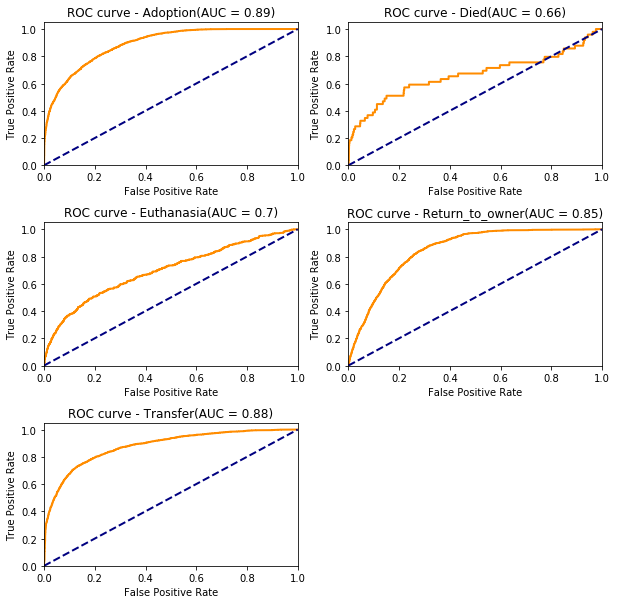

In [69]:
y_test_bin = label_binarize(y_test[:,0], GB.classes_)
plotROCCurves(GB.classes_, labelMapper.features[0][1].inverse_transform(GB.classes_), y_test_bin, proba)

Also generate a confusion matrix for the predictions.

In [44]:
from sklearn.metrics import confusion_matrix
print labelMapper.features[0][1].inverse_transform(GB.classes_)
cm = confusion_matrix(y_test[:,0], preds)#y_train[:,0]
cm


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
3750
3259
3750


array([[2646,    0,    1,  327,  285],
       [   6,    0,    2,    5,   36],
       [  78,    1,    7,  107,  259],
       [ 555,    0,    0,  681,  207],
       [ 465,    0,    3,  245, 2103]])

Load the Kaggle test set and prepare predictions to submit to Kaggle

In [ ]:
testdf = pd.read_csv("test.csv")

splitSex(testdf)
cleanupBreed(testdf)
testdf = processBreed(testdf, breedsTDM)    
processAge(testdf)    
processDate(testdf)
processWeekend(testdf)
processName(testdf)
processColor(testdf)


prepared_testdf = testdf.copy()
print prepared_testdf.head()
prepared_testdf = prepared_testdf.drop(["ID", "Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_testdf.head()

prepared_fitted_testdf = mapper.fit_transform(prepared_testdf)

print prepared_fitted_testdf.columns
# Drop redundant columns to avoid the Dummy Variable Trap
prepared_fitted_testdf = prepared_fitted_testdf.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor" ], axis=1)
prepared_fitted_testdf.head()

In [ ]:
X_kaggle_test = prepared_fitted_testdf.values
print prepared_fitted_testdf.head()
print prepared_fitted_df.head()
preds = GB.predict(X_kaggle_test[:,final_support])
probs = GB.predict_proba(X_kaggle_test[:,final_support])
print GB.classes_
print labelMapper.features[0][1].inverse_transform(GB.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf